<a href="https://colab.research.google.com/github/intTing/1/blob/main/4_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Function to compute Distance (4 metrics)
SPD (Symmetric Positive Definite) matrix A, B

Frobenius Distance: $$d_E(A, B) = \|A - B\|_F$$
Log-Euclidean Distance: $$d_{LE}(A, B) = \|\log A - \log B\|_F$$
Affine-Invariant Distance: $$d_{AI}(A, B) = \|\log(A^{-1/2} B A^{-1/2})\|_F$$

In [1]:
import numpy as np
from scipy.linalg import logm, sqrtm, inv, expm, eigh

# 2 symmetric positive definite matrices of dimension 2×2
#S1 = np.array([[17.66, 22.94],[22.94, 59.47]])
#S2 = np.array([[64.72, 31.67],[31.67, 17.09]])

S1 = np.diag([2, 1])
S2 = np.array([[2, 1],[1, 1]]) # Rotate

# Frobenius (Euclidean) distance
# Frobenius distance = Euclidean norm of (A - B)
def frobenius_distance(A, B):
    return np.linalg.norm(A - B, ord='fro')

# Log-Euclidean distance
# take matrix logarithm, then use Frobenius distance
def log_euclidean_distance(A, B):
    logA = logm(A)
    logB = logm(B)
    return np.linalg.norm(logA - logB, ord='fro')

# Riemannian distance
def Riemannian_distance(A, B):
    A_inv_sqrt = inv(sqrtm(A)) # inverse square root of A: A^-1/2
    sqabsqa = A_inv_sqrt @ B @ A_inv_sqrt # A^-1/2 B A^-1/2
    log_sqabsqa = logm(sqabsqa) # log(A^-1/2 B A^-1/2)
    return np.linalg.norm(log_sqabsqa, ord='fro') # || log(A^-1/2 B A^-1/2) ||

# print the results
d_frob = frobenius_distance(S1, S2)
d_logeuc = log_euclidean_distance(S1, S2)
d_rieman = Riemannian_distance(S1, S2)

print("Frobenius Distance: ", d_frob)
print("Log-Euclidean Distance: ", d_logeuc)
print("Riemannian distance: ", d_rieman)


Frobenius Distance:  1.4142135623730951
Log-Euclidean Distance:  1.3176866435923882
Riemannian distance:  1.3393525699943585


$$X = U D U^\top, \quad Y = V \Lambda V^\top$$
$$A = \log(VU^\top), \quad L = \log(D^{-1} \Lambda)$$

Scale-Rotation Distance: $$d^2((U,D), (V,\Lambda)) = \frac{k}{2} \|\log(VU^\top)\|_F^2 + \|\log(D^{-1}\Lambda)\|_F^2$$

$$d_{SR}(X, Y) = \sqrt{\frac{k}{2}\|A\|_F^2 + \|L\|_F^2} $$

In [2]:
from scipy.linalg import norm

# Function to compute the scale-rotation distance between two SPD matrices
def scale_rotation_distance(X, Y, k=1.0):
    """
    Compute the scale-rotation distance between SPD matrices X and Y.

    Parameters:
    - X, Y: SPD matrices (numpy arrays)
    - k: weight factor on rotation term (default = 1.0)

    Returns:
    - scalar value of scale-rotation distance
    """
    # Eigen-decomposition
    D_vals, U = eigh(X)
    Lambda_vals, V = eigh(Y)
    # Lambda_vals = array of eigenvalues of Y
    # V = eigenvector matrix of Y

    # Convert eigenvalues to diagonal matrices
    D = np.diag(D_vals)
    Lambda = np.diag(Lambda_vals)

    # Compute the rotational and scaling components
    A = logm(V @ U.T)                  # Log of rotation matrix
    L = logm(np.linalg.inv(D) @ Lambda)  # Log of scale transformation

    # Frobenius norms and final distance formula
    # dist = np.sqrt(k * norm(A, 'fro')**2 + norm(L, 'fro')**2)
    dist = np.sqrt(0.5 * k * norm(A, 'fro')**2 + norm(L, 'fro')**2)
    return dist

# Calculate and display the scale-rotation distance between S1 and S2
d_sc = scale_rotation_distance(S1, S2)
print("Scale-rotation: ", d_sc)

Scale-rotation:  1.1424594829556767


**Determine whether the matrix is SPD**

In [3]:
Y = np.array([[2, 1],[1, 1]])
def is_spd(A):
    return np.allclose(A, A.T) and np.all(np.linalg.eigvals(A) > 0)
    # Determine whether the matrix is symmetric
    # Determine whether all eigenvalues are greater than 0 (positive definite) # Calculate the eigenvalues ​​of matrix A

print("Y is the SPD matrix" if is_spd(Y) else "Y is not an SPD matrix")

Y is the SPD matrix


# Function to compute Geodesic
Affine-Invariant Geodesic: $$\gamma(t) = A^{1/2} \exp\left(t \cdot \log\left(A^{-1/2} B A^{-1/2}\right)\right) A^{1/2}, \quad t \in [0, 1]$$
A and B are SPD matrices, then $$A^{-1/2} B A^{-1/2}$$ is SPD: $$\gamma(t) = A^{1/2} \left( A^{-1/2} B A^{-1/2} \right)^t A^{1/2}$$

In [4]:
# Frobenius Geodesic
def geodesic_frobenius(S1, S2, t):
    return (1 - t) * S1 + t * S2

# Log-Euclidean Geodesic
def geodesic_logeuclidean(S1, S2, t):
    logS1 = logm(S1)
    logS2 = logm(S2)
    return expm((1 - t) * logS1 + t * logS2)

# Affine-Invariant Geodesic
def geodesic_affine_invariant(S1, S2, t):
    S1_sqrt = sqrtm(S1) # S1^{1/2}
    S1_inv_sqrt = inv(S1_sqrt) # S1^{-1/2}
    middle = S1_inv_sqrt @ S2 @ S1_inv_sqrt
    middle_power = expm(t * logm(middle))
    return S1_sqrt @ middle_power @ S1_sqrt

# Scale-rotation curve (not geodesic)
def curve_scale_rotation(X, Y, t):
    """
    Compute the scale-rotation curve point χ(t) between SPD matrices X and Y.
    X = U D U^T, Y = V Λ V^T are eigen-decompositions of X and Y.
    - A = log(V U^T) represents the rotational difference
    - L = log(D^{-1} Λ) represents the scaling difference
    The general scaling–rotation curve is: χ(t) = [exp(tA) U] [exp(tL) D] [exp(tA) U]^T
    """
    # Eigen-decomposition of X and Y
    D_vals, U = eigh(X)
    Lambda_vals, V = eigh(Y)
    # Lambda_vals = array of eigenvalues of Y
    # V = eigenvector matrix of Y

    # Form diagonal matrices from eigenvalues
    D = np.diag(D_vals)
    Lambda = np.diag(Lambda_vals)

    # Compute A = log(V U^T) in so(n)
    A = logm(V @ U.T)

    # Compute L = log(D^{-1} Λ)
    D_inv = np.linalg.inv(D)
    L = logm(D_inv @ Lambda)

    exp_tA = expm(t * A)
    exp_tL = expm(t * L)

    Ut = exp_tA @ U
    Dt = exp_tL @ D  # Dt theoretical diagonal angle (within numerical tolerance)

    # Reconstruct SPD matrix on the curve
    Xt = Ut @ Dt @ Ut.T
    return Xt

**Scale-rotation curve: χ(t) = [exp(tA) · U] · [exp(tL) · D] · [exp(tA) · U]^T**

A ∈ so(n), Describing Rotation

L ∈ Sym(n), Description Scaling

In [5]:
t_vals = np.linspace(0, 1, 5)
# Output 5 interpolation points (t=0,0.25,0.5,0.75,1)
# interpolate and print several points on a geodesic path

print("Geodesic path (Frobenius):")
for t in t_vals:
    print(geodesic_frobenius(S1, S2, t))

print("\nGeodesic path (Log-Euclidean):")
for t in t_vals:
    print(geodesic_logeuclidean(S1, S2, t))

print("\nGeodesic path (Affine-Invariant):")
for t in t_vals:
    print(geodesic_affine_invariant(S1, S2, t))

print("\nCurve path (scale-rotation):")
for t in t_vals:
    print(curve_scale_rotation(S1, S2, t))

Geodesic path (Frobenius):
[[2. 0.]
 [0. 1.]]
[[2.   0.25]
 [0.25 1.  ]]
[[2.  0.5]
 [0.5 1. ]]
[[2.   0.75]
 [0.75 1.  ]]
[[2. 1.]
 [1. 1.]]

Geodesic path (Log-Euclidean):
[[2. 0.]
 [0. 1.]]
[[1.90741854 0.28759989]
 [0.28759989 0.92507569]]
[[1.88308306 0.54100977]
 [0.54100977 0.90644177]]
[[1.91630952 0.7746606 ]
 [0.7746606  0.93372503]]
[[2. 1.]
 [1. 1.]]

Geodesic path (Affine-Invariant):
[[2. 0.]
 [0. 1.]]
[[1.87871017 0.2880679 ]
 [0.2880679  0.93935508]]
[[1.84775907 0.5411961 ]
 [0.5411961  0.92387953]]
[[1.8916031  0.77451535]
 [0.77451535 0.94580155]]
[[2. 1.]
 [1. 1.]]

Curve path (scale-rotation):
[[2. 0.]
 [0. 1.]]
[[2.1135225 0.1848815]
 [0.1848815 0.8119024]]
[[2.16352323 0.43904111]
 [0.43904111 0.74275637]]
[[2.12842799 0.72404788]
 [0.72404788 0.80503191]]
[[2. 1.]
 [1. 1.]]


In [6]:
# Calculate the maximum radius of all ellipses on the geodesic
all_matrices = []
selected_ts = np.linspace(0, 1, 5)

for t in selected_ts:
    all_matrices.extend([
        geodesic_frobenius(S1, S2, t),
        geodesic_logeuclidean(S1, S2, t),
        geodesic_affine_invariant(S1, S2, t),
        curve_scale_rotation(S1, S2, t)
    ])

max_radius = max(np.sqrt(np.max(np.linalg.eigvalsh(S))) for S in all_matrices)

In [7]:
def plot_spd_ellipse(S, ax, color='green', radius=1.5):
    theta = np.linspace(0, 2 * np.pi, 200)
    circle = np.vstack((np.cos(theta), np.sin(theta)))
    ell = sqrtm(S) @ circle
    ax.plot(ell[0, :], ell[1, :], color=color)

    ax.set_aspect('equal')
    ax.set_xlim(-radius, radius)
    ax.set_ylim(-radius, radius)
    ax.axis('off') # Hide axis

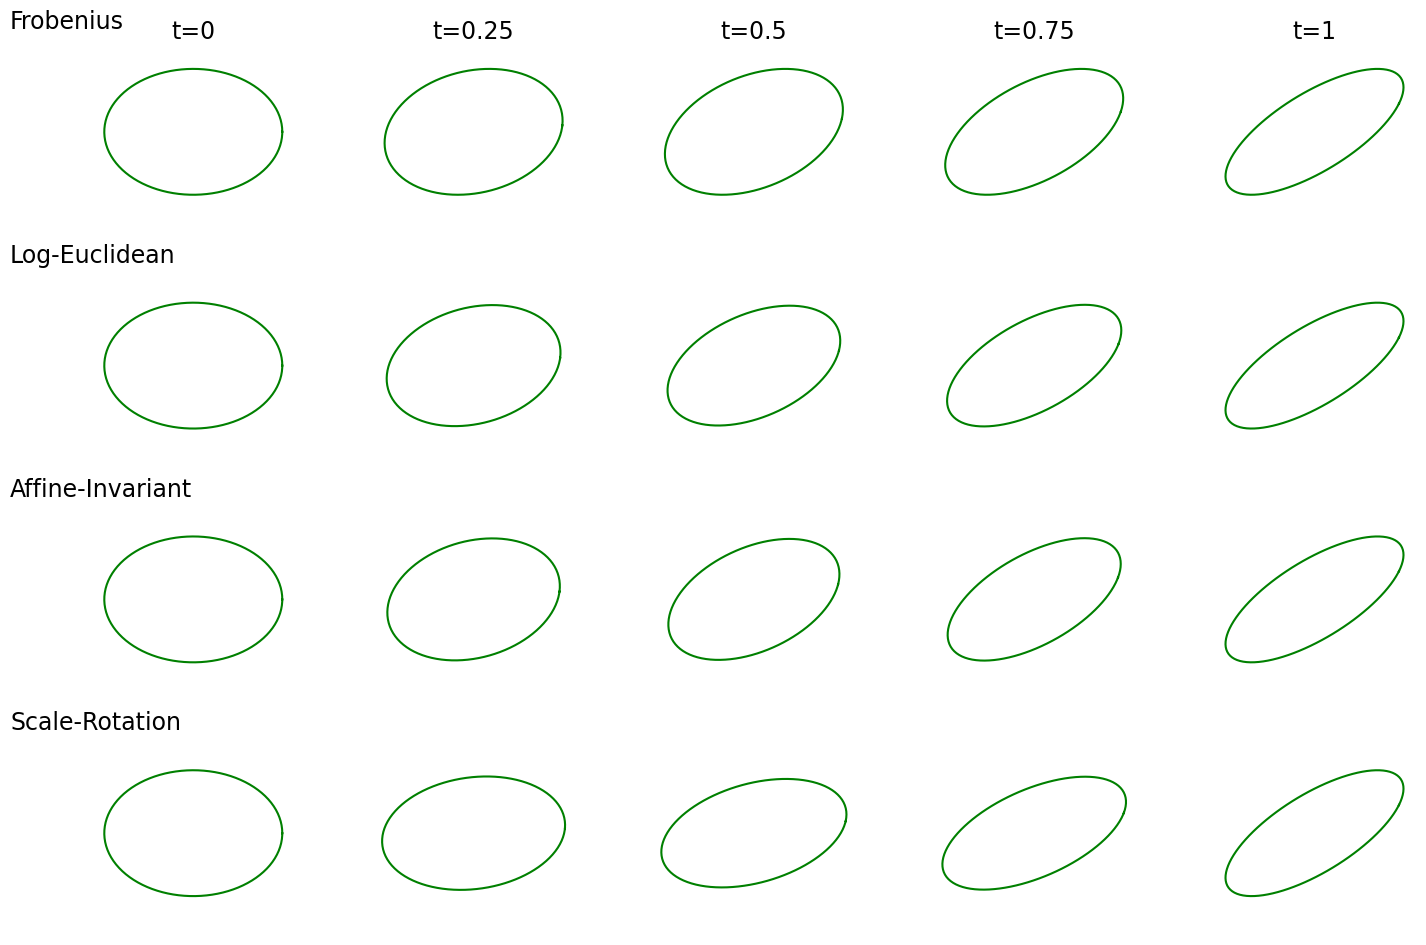

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 5, figsize=(15, 10))
row_titles = ["Frobenius", "Log-Euclidean", "Affine-Invariant", "Scale-Rotation"]
selected_ts = np.linspace(0, 1, 5)

for i, t in enumerate(selected_ts):
    plot_spd_ellipse(geodesic_frobenius(S1, S2, t), axes[0, i], radius=max_radius)
    plot_spd_ellipse(geodesic_logeuclidean(S1, S2, t), axes[1, i], radius=max_radius)
    plot_spd_ellipse(geodesic_affine_invariant(S1, S2, t), axes[2, i], radius=max_radius)
    plot_spd_ellipse(curve_scale_rotation(S1, S2, t), axes[3, i], radius=max_radius)

# Column Labels
col_titles = [f"t={t:.2f}".rstrip('0').rstrip('.') for t in selected_ts]
for j, lab in enumerate(col_titles):
    axes[0, j].text(0.5, 1.05, lab, transform=axes[0, j].transAxes,
                    ha='center', va='top', fontsize=17)

# Row Labels
for r, title in enumerate(row_titles):
    axes[r, 0].text(-0.4, 1.1, title, transform=axes[r, 0].transAxes,
                    ha='left', va='top', fontsize=17)

# plt.suptitle("Geodesic/Curve Ellipse Paths with Equal Axis Scaling", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [9]:
from scipy.linalg import sqrtm, inv, logm, expm, det

t_vals = np.linspace(0, 1, 100)

# Compute determinant
# det(γ(t))
det_frob = [det(geodesic_frobenius(S1, S2, t)) for t in t_vals]
det_logeuc = [det(geodesic_logeuclidean(S1, S2, t)) for t in t_vals]
det_affine = [det(geodesic_affine_invariant(S1, S2, t)) for t in t_vals]
det_sc = [det(curve_scale_rotation(S1, S2, t)) for t in t_vals]

print("det(γ(t)) computed at t=0.5:")
print(f"Frobenius: {det_frob[50]:.6f}")
print(f"Log-Euclidean: {det_logeuc[50]:.6f}")
print(f"Affine-Invariant: {det_affine[50]:.6f}")
print(f"Scale-Rotation det: {det_sc[50]:.6f}") # det(χ(t)) computed at t=0.5

det(γ(t)) computed at t=0.5:
Frobenius: 1.744924
Log-Euclidean: 1.409271
Affine-Invariant: 1.409271
Scale-Rotation det: 1.409271


In [10]:
from scipy.linalg import sqrtm, inv, logm, expm, eigvalsh

# compute FA
def compute_fa(matrix):
    eigvals = eigvalsh(matrix)
    n = len(eigvals)
    lambda_mean = np.mean(eigvals)
    numerator = np.sqrt(np.sum((eigvals - lambda_mean)**2))
    denominator = np.sqrt(np.sum(eigvals**2))
    fa = np.sqrt(n / (n - 1)) * numerator / denominator if denominator > 0 else 0
    return fa

fa_frobenius = [compute_fa(geodesic_frobenius(S1, S2, t)) for t in t_vals]
fa_logeuc = [compute_fa(geodesic_logeuclidean(S1, S2, t)) for t in t_vals]
fa_affine = [compute_fa(geodesic_affine_invariant(S1, S2, t)) for t in t_vals]
fa_sc = [compute_fa(curve_scale_rotation(S1, S2, t)) for t in t_vals]

print("FA at t=0.5:")
print(f"Frobenius FA: {fa_frobenius[50]:.6f}")
print(f"Log-Euclidean FA: {fa_logeuc[50]:.6f}")
print(f"Affine-Invariant FA: {fa_affine[50]:.6f}")
print(f"Scale-Rotation FA: {fa_sc[50]:.6f}")

FA at t=0.5:
Frobenius FA: 0.605517
Log-Euclidean FA: 0.657451
Affine-Invariant FA: 0.648575
Scale-Rotation FA: 0.706574


In [11]:
# trace(γ(t))
trace_frobenius = [np.trace(geodesic_frobenius(S1, S2, t)) for t in t_vals]
trace_logeuclidean = [np.trace(geodesic_logeuclidean(S1, S2, t)) for t in t_vals]
trace_affine = [np.trace(geodesic_affine_invariant(S1, S2, t)) for t in t_vals]
trace_sc = [np.trace(curve_scale_rotation(S1, S2, t)) for t in t_vals]

print("Trace of γ(t) at t = 0.5:")
print(f"Frobenius: {trace_frobenius[50]:.6f}")
print(f"Log-Euclidean: {trace_logeuclidean[50]:.6f}")
print(f"Affine-Invariant: {trace_affine[50]:.6f}")
print(f"Scale-Rotation: {trace_sc[50]:.6f}")

Trace of γ(t) at t = 0.5:
Frobenius: 3.000000
Log-Euclidean: 2.789781
Affine-Invariant: 2.771920
Scale-Rotation: 2.906397


In [12]:
from scipy.linalg import eigvalsh

def compute_ga(matrix):
    eigvals = eigvalsh(matrix)
    log_eigs = np.log(eigvals)
    mean_log = np.mean(log_eigs)
    ga = np.sqrt(np.sum((log_eigs - mean_log) ** 2))
    return ga

t_vals = np.linspace(0, 1, 100)
ga_frobenius = [compute_ga(geodesic_frobenius(S1, S2, t)) for t in t_vals]
ga_logeuc = [compute_ga(geodesic_logeuclidean(S1, S2, t)) for t in t_vals]
ga_affine = [compute_ga(geodesic_affine_invariant(S1, S2, t)) for t in t_vals]
ga_sc = [compute_ga(curve_scale_rotation(S1, S2, t)) for t in t_vals]

print("GA at t=0.5:")
print(f"Frobenius GA: {ga_frobenius[50]:.6f}")
print(f"Log-Euclidean GA: {ga_logeuc[50]:.6f}")
print(f"Affine-Invariant GA: {ga_affine[50]:.6f}")
print(f"Scale-Rotation GA: {ga_sc[50]:.6f}")

GA at t=0.5:
Frobenius GA: 0.728246
Log-Euclidean GA: 0.824946
Affine-Invariant GA: 0.807498
Scale-Rotation GA: 0.930000


# Check: Dt should be diagonal for all t

In [13]:
print("Checking if Dt is diagonal at each t in curve_scale_rotation:")

non_diag_flags = []
for t in t_vals:
    # S1 = U D U^T
    D_vals, U = eigh(S1)
    # D_vals = array of eigenvalues of S1
    # U = eigenvector matrix of S1

    # S2 = V Λ V^T
    Lambda_vals, V = eigh(S2)

    D = np.diag(D_vals) # Construct diagonal matrix D
    Lambda = np.diag(Lambda_vals) # Construct diagonal matrix Lambda

    A = logm(V @ U.T) # Compute A = log(V U^T)
    D_inv = np.linalg.inv(D)
    L = logm(D_inv @ Lambda) # L = log(D^{-1} Λ)
    exp_tL = expm(t * L)
    Dt = exp_tL @ D # D(t) = exp(tL) * D # is the scaled diagonal matrix corresponding to the interpolation time t, the middle part of the geodesic

    is_diag = np.allclose(Dt, np.diag(np.diag(Dt)), atol=1e-8) # Determine whether Dt is diagonal matrix (Tolerate small numerical errors)
    non_diag_flags.append(not is_diag) # Record whether it is non-diagonal
    print(f"t = {t:.2f} --> {'Diagonal' if is_diag else 'Non-diagonal'}")


"""
np.diag(Dt):
If Dt is a 2D matrix (e.g., 2×2, 3×3), then np.diag(Dt) extracts its main diagonal elements and returns a 1D array.
np.diag(np.diag(Dt)):
Puts the extracted diagonal elements back into a new diagonal matrix, with all other positions set to 0.
This constructs a pure diagonal matrix, preserving only the original main diagonal.
np.allclose: Determine whether the original matrix Dt and the diagonal matrix we reconstructed by extracting its diagonal are almost equal?
"""

# Summary
if any(non_diag_flags):
    print("\nWarning: Dt is not diagonal for some values of t.")
else:
    print("\nAll Dt matrices are diagonal across t.")

Checking if Dt is diagonal at each t in curve_scale_rotation:
t = 0.00 --> Diagonal
t = 0.01 --> Diagonal
t = 0.02 --> Diagonal
t = 0.03 --> Diagonal
t = 0.04 --> Diagonal
t = 0.05 --> Diagonal
t = 0.06 --> Diagonal
t = 0.07 --> Diagonal
t = 0.08 --> Diagonal
t = 0.09 --> Diagonal
t = 0.10 --> Diagonal
t = 0.11 --> Diagonal
t = 0.12 --> Diagonal
t = 0.13 --> Diagonal
t = 0.14 --> Diagonal
t = 0.15 --> Diagonal
t = 0.16 --> Diagonal
t = 0.17 --> Diagonal
t = 0.18 --> Diagonal
t = 0.19 --> Diagonal
t = 0.20 --> Diagonal
t = 0.21 --> Diagonal
t = 0.22 --> Diagonal
t = 0.23 --> Diagonal
t = 0.24 --> Diagonal
t = 0.25 --> Diagonal
t = 0.26 --> Diagonal
t = 0.27 --> Diagonal
t = 0.28 --> Diagonal
t = 0.29 --> Diagonal
t = 0.30 --> Diagonal
t = 0.31 --> Diagonal
t = 0.32 --> Diagonal
t = 0.33 --> Diagonal
t = 0.34 --> Diagonal
t = 0.35 --> Diagonal
t = 0.36 --> Diagonal
t = 0.37 --> Diagonal
t = 0.38 --> Diagonal
t = 0.39 --> Diagonal
t = 0.40 --> Diagonal
t = 0.41 --> Diagonal
t = 0.42 --> D

# Check: try simple test case
X = [[1, 0], [0, 1]]

Y = [[1, 0], [0, 1]]

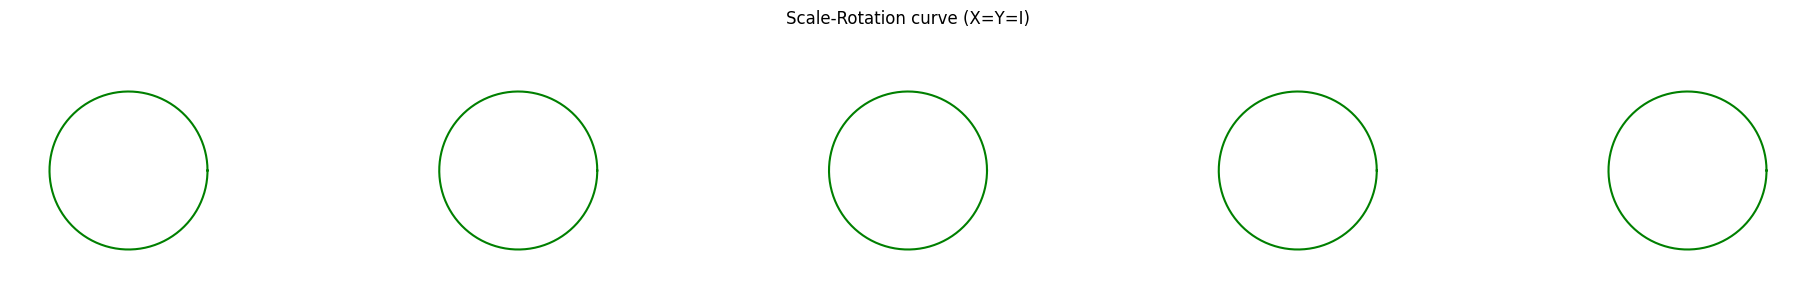

In [14]:
X_test = np.eye(2)  # 2×2 identity matrix
Y_test = np.eye(2)

fig, axes = plt.subplots(1, 5, figsize=(20, 3))
row_titles = ["Scale-Rotation"]
selected_ts = np.linspace(0, 1, 5)

# For each t, calculate curve path and draw ellipse
for i, t in enumerate(selected_ts):
    plot_spd_ellipse(curve_scale_rotation(X_test, Y_test, t), axes[i])
    # axes[i].set_title(f"t={t:.2f}")

for ax in axes:
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')

plt.suptitle("Scale-Rotation curve (X=Y=I)")
plt.tight_layout()
plt.show()

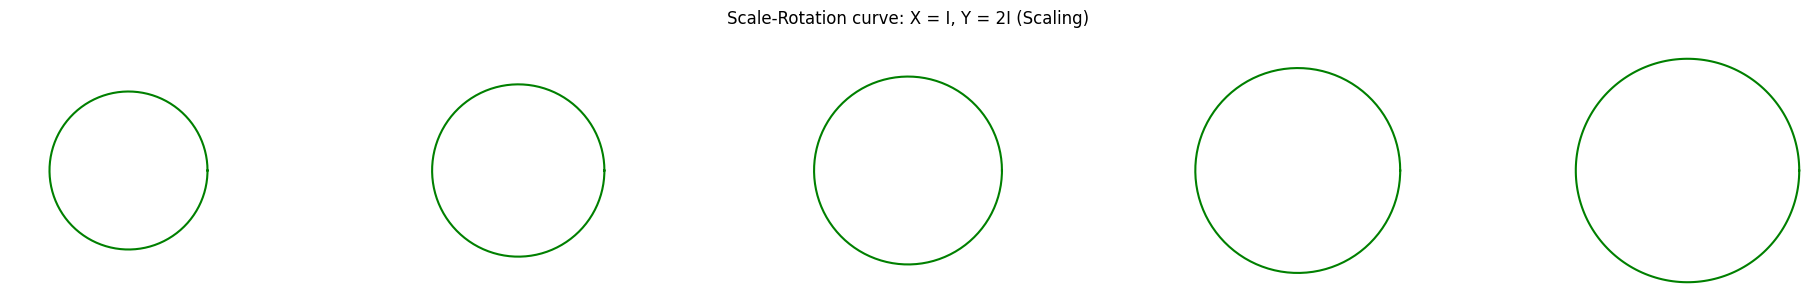

In [15]:
X_test2 = np.eye(2)
Y_test2 = 2 * np.eye(2)

fig, axes = plt.subplots(1, 5, figsize=(20, 3))
selected_ts = np.linspace(0, 1, 5)  # t = 0, 0.25, ..., 1

for i, t in enumerate(selected_ts):
  plot_spd_ellipse(curve_scale_rotation(X_test2, Y_test2, t), axes[i])

for ax in axes:
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')

plt.suptitle("Scale-Rotation curve: X = I, Y = 2I (Scaling)")
plt.tight_layout()
plt.show()


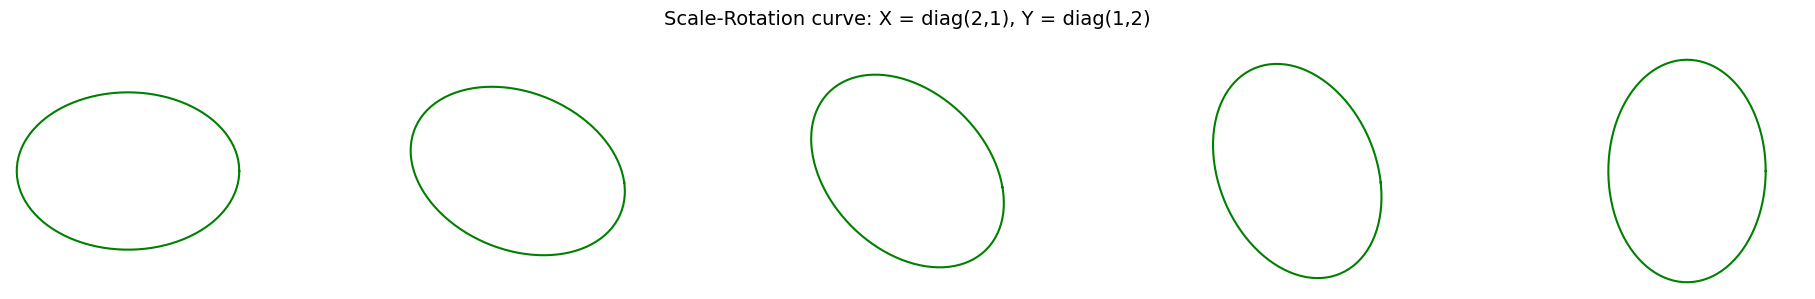

In [16]:
X_test3 = np.diag([2, 1])
Y_test3 = np.diag([1, 2])

fig, axes = plt.subplots(1, 5, figsize=(20, 3))
for i, t in enumerate(selected_ts):
  plot_spd_ellipse(curve_scale_rotation(X_test3, Y_test3, t), axes[i])

for ax in axes:
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')

plt.suptitle("Scale-Rotation curve: X = diag(2,1), Y = diag(1,2)", fontsize=14)
plt.tight_layout()
plt.show()

# Analyze the situation where k is small and k is large

In [17]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.linalg import logm, expm, eigh

# Define the SPD matrices: X = diag(1,2), Y = diag(2,1)
D = np.diag([2, 1])
Lambda = np.diag([1, 2])
U = np.eye(2)
V = np.eye(2)  # No rotation here, only change in eigenvalue order

# Generate all equivalent versions of (U,D) and (V,Lambda)
def generate_versions_SO(U, D):
    versions = []
    perms = [np.eye(2), np.array([[0,1],[1,0]])]  # 2 permutations
    signs = [np.diag([1,1]), np.diag([1,-1]), np.diag([-1,1]), np.diag([-1,-1])] # 4 signs
    for P in perms:
        Dp = P @ D @ P.T          # Permutation eigenvalues
        for S in signs:
            Up = U @ P @ S        # First permute the columns, then ±1 column by column
            if np.linalg.det(Up) > 0:   # Keep only SO(2)
                versions.append((Up, Dp))
    return versions

X_versions = generate_versions_SO(U, D)
Y_versions = generate_versions_SO(V, Lambda)

In [18]:
# Choose best version pair for each k
k_values = [0.1, 1]
colors = ['blue', 'green']
colors = ['tab:blue', 'tab:blue']
best_paths = {}

for k in k_values:
    min_dist = np.inf
    best_combo = None
    for (U, D) in X_versions:
        for (V, Lambda) in Y_versions:
            try:
                A = logm(V @ U.T)
                L = logm(np.linalg.inv(D) @ Lambda)
                dist = (k/2) * np.linalg.norm(A, 'fro')**2 + np.linalg.norm(L, 'fro')**2
                if dist < min_dist: # Select the pairs (U, D), (V, Lambda) with the minimum distance
                    min_dist = dist
                    best_combo = (U, D, V, Lambda)
            except:
                continue
    best_paths[k] = best_combo

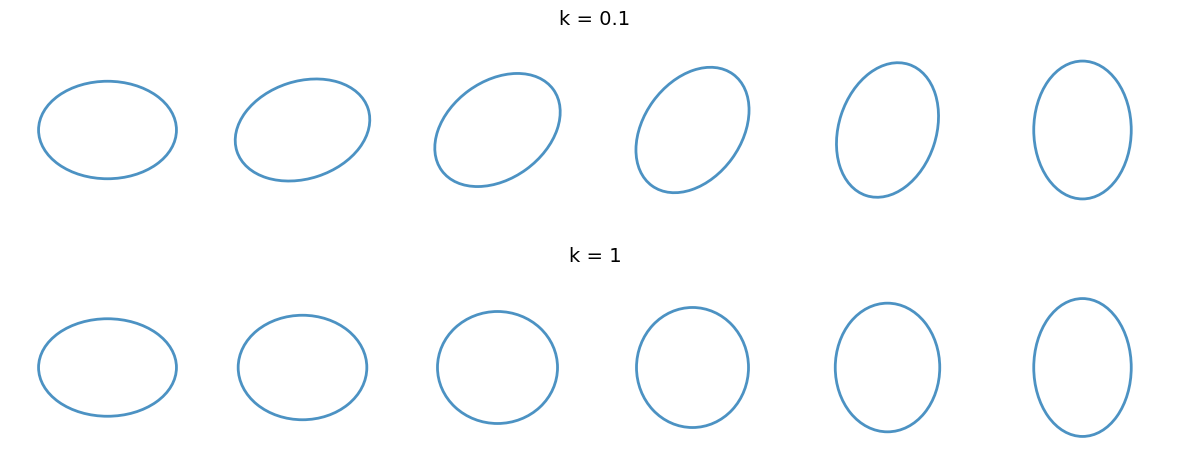

In [19]:
# Re-plot with only k = 0.1 and k = 1 for clearer comparison
fig, axs = plt.subplots(len(k_values), 1, figsize=(12, 5))
for idx, k in enumerate(k_values):
    ax = axs[idx]
    # ax.set_title(f"Scaling–Rotation Curve: X = diag(2,1), Y = diag(1,2), k = {k}", fontsize=14)
    ax.set_title(f"k = {k}", fontsize=14)
    ax.set_xlim(-2, 22)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    # ax.axhline(0, color='gray', lw=0.5)
    ax.axis('off')

    U, D, V, Lambda = best_paths[k] # best_paths
    A = logm(V @ U.T)
    L = logm(np.linalg.inv(D) @ Lambda)

    step = 4.0
    for i, t in enumerate(np.linspace(0, 1, 6)):
        R_t = expm(A * t)
        S_t = expm(L * t)
        Xt = R_t @ U @ D @ S_t @ U.T @ R_t.T

        vals, vecs = eigh(Xt)
        order = vals.argsort()[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

        width, height = 2 * np.sqrt(vals)
        trans = transforms.Affine2D().translate(i * step, 0) + ax.transData
        ellipse = Ellipse(xy=(0, 0), width=width, height=height,
                          angle=angle, edgecolor=colors[idx], facecolor='none',
                          lw=2, alpha=0.8, transform=trans)
        ax.add_patch(ellipse)

    ax.set_yticks([])
    ax.set_xticks([])

plt.tight_layout()
plt.show()


**Scaling–Rotation Curve interpolation path from X=diag(1,2) to Y=diag(2,1) corresponding to 2 different k values.**

# Decomposition case：

For SPD matric $X \in \mathbb{R}^{n \times n}$, can be written in $X = U D U^\top$.

An SPD matrix can actually have multiple sets of $(U, D)$, all satisfying $X = U D U^\top$.

**Only enumerate the decompositions of U ∈ SO(d) (detU=+1)**

In [20]:
import numpy as np
from itertools import permutations, product
from scipy.linalg import eigh  # Symmetrical matrix eigendecomposition

def all_decompositions_SO(S, tol=1e-12):
    """
    Return all (U, D) eigendecompositions of S, but only keep those with U ∈ SO(d) (det(U)=+1).
    This is consistent with the count in Jung (2015): d! * 2^(d-1).
    This only discretely enumerates the finite equivalent versions produced by permutation+sign flip.
    Only a finite number of permutation+sign flip versions are enumerated.
    """
    # Eigen decomposition
    eigvals, eigvecs = eigh(S)
    # eigvecs columns are unit orthogonal vectors
    # Input matrix S, S = eigvecs @ diag(eigvals) @ eigvecs.T
    d = eigvecs.shape[0]

    idx_perms   = list(permutations(range(d)))            # d! permutations # eigenvalues permutations
    sign_combos = list(product([1, -1], repeat=d))        # 2^d symbol combinations (det=+1 will be filtered later)

    decomps = []
    for perm in idx_perms:
        D = np.diag([eigvals[i] for i in perm])           # permuted eigenvalues
        V = eigvecs[:, perm]                              # permuted eigenvectors
        for signs in sign_combos:
            Ucand = V @ np.diag(signs)                    # Column sign flip
            # Only keep det(U)=+1 (i.e. U ∈ SO(d))
            if np.linalg.det(Ucand) > 0 + tol:
                decomps.append((Ucand, D))
    return decomps


Use the SO(d) version to search for the "optimal decomposition pair"

In [21]:
from scipy.linalg import logm

# Scaling–Rotation distance between two decompositions (U1,D1) and (U2,D2).
def scale_rotation_distance(U1, D1, U2, D2, k=1.0):
    log_rot   = logm(U2 @ U1.T) # Rotation term A
    log_scale = logm(np.linalg.inv(D1) @ D2) # Scaling term L
    return (k / 2) * np.linalg.norm(log_rot, 'fro')**2 + np.linalg.norm(log_scale, 'fro')**2


# Enumerate all versions of X and Y, calculate the corresponding square distances, and take the minimum value.
def find_optimal_decomposition_pair_SO(X, Y, k=1.0):
    dec_X = all_decompositions_SO(X)
    dec_Y = all_decompositions_SO(Y)

    best_pair = None
    min_dist  = np.inf
    all_pairs = []

    for (U1, D1) in dec_X:
        for (U2, D2) in dec_Y:
            dval = scale_rotation_distance(U1, D1, U2, D2, k)
            all_pairs.append((U1, D1, U2, D2, dval))
            if dval < min_dist: # Select the optimal distance (min)
                min_dist  = dval
                best_pair = (U1, D1, U2, D2)
    return best_pair, all_pairs


curve compute

In [22]:
from scipy.linalg import expm

def curve_from_decomposition(U1, D1, U2, D2, t):
    """
    Scaling–Rotation curve χ(t) from (U1,D1) to (U2,D2).
    NOTE: This is the SR curve (interpolation path), not the "distance"
    """
    A = logm(U2 @ U1.T)
    L = logm(np.linalg.inv(D1) @ D2)
    Ut = expm(t * A) @ U1
    Dt = expm(t * L) @ D1
    return Ut @ Dt @ Ut.T


Simple check: 2 dimensions should be 4 combinations

In [23]:
X = np.diag([2.0, 1.0])
decs = all_decompositions_SO(X)
print("SO Number of combinations =", len(decs))  # Expected output 4
for i,(U,D) in enumerate(decs,1):
    print(f"Case {i}, det(U)={np.linalg.det(U):.0f}")
    print("UDU^T ≈\n", U @ D @ U.T, "\n")

SO Number of combinations = 4
Case 1, det(U)=1
UDU^T ≈
 [[2. 0.]
 [0. 1.]] 

Case 2, det(U)=1
UDU^T ≈
 [[2. 0.]
 [0. 1.]] 

Case 3, det(U)=1
UDU^T ≈
 [[2. 0.]
 [0. 1.]] 

Case 4, det(U)=1
UDU^T ≈
 [[2. 0.]
 [0. 1.]] 



Find the optimal decomposition pair

In [24]:
X = np.diag([2, 1])
Y = np.diag([1, 2])

(best_U1, best_D1, best_U2, best_D2), best_dist = find_optimal_decomposition_pair_SO(X, Y, k=1.0)

# print("Minimum distance:", best_dist)
print("optimal U1:\n", best_U1)
print("optimal D1:\n", best_D1)
print("optimal U2:\n", best_U2)
print("optimal D2:\n", best_D2)


optimal U1:
 [[ 0.  1.]
 [-1.  0.]]
optimal D1:
 [[1. 0.]
 [0. 2.]]
optimal U2:
 [[ 0.  1.]
 [-1.  0.]]
optimal D2:
 [[2. 0.]
 [0. 1.]]


For any 2 SPD matrices X,Y, write them into eigen-decomposition $X = U_1 D_1 U_1^\top$, $Y = U_2 D_2 U_2^\top$

Write them all as eigen-decomposition.

When the dimension is 2, there are four cases. These four cases are displayed in the Python output.

In [25]:
X = np.diag([2, 1])

decomps = all_decompositions_SO(X)
# print("Reconstruct X = U D U^T =\n", U @ D @ U.T)
print(f"Total number of combinations (SO version): {len(decomps)}")  # expected to be 4

# Print all 4 possible combinations of (U, D)
for i, (U, D) in enumerate(decomps, 1):
    reconstructed = U @ D @ U.T # X = UDU^T
    print(f"\ncombination {i}:  det(U)={np.linalg.det(U):+.0f}")
    print("U =\n", U)
    print("D =\n", D)
    print("-" * 40)

print("Reconstruct X = U D U^T =\n", reconstructed)

Total number of combinations (SO version): 4

combination 1:  det(U)=+1
U =
 [[ 0.  1.]
 [-1.  0.]]
D =
 [[1. 0.]
 [0. 2.]]
----------------------------------------

combination 2:  det(U)=+1
U =
 [[ 0. -1.]
 [ 1.  0.]]
D =
 [[1. 0.]
 [0. 2.]]
----------------------------------------

combination 3:  det(U)=+1
U =
 [[-1.  0.]
 [ 0. -1.]]
D =
 [[2. 0.]
 [0. 1.]]
----------------------------------------

combination 4:  det(U)=+1
U =
 [[1. 0.]
 [0. 1.]]
D =
 [[2. 0.]
 [0. 1.]]
----------------------------------------
Reconstruct X = U D U^T =
 [[2. 0.]
 [0. 1.]]



The code above (enumerating all possible combinations and finding the shortest distance combination) will be further expanded.

This logic will be integrated into geodesic interpolation and visualization (drawing the optimal combination path vs. the non-optimal combination path).

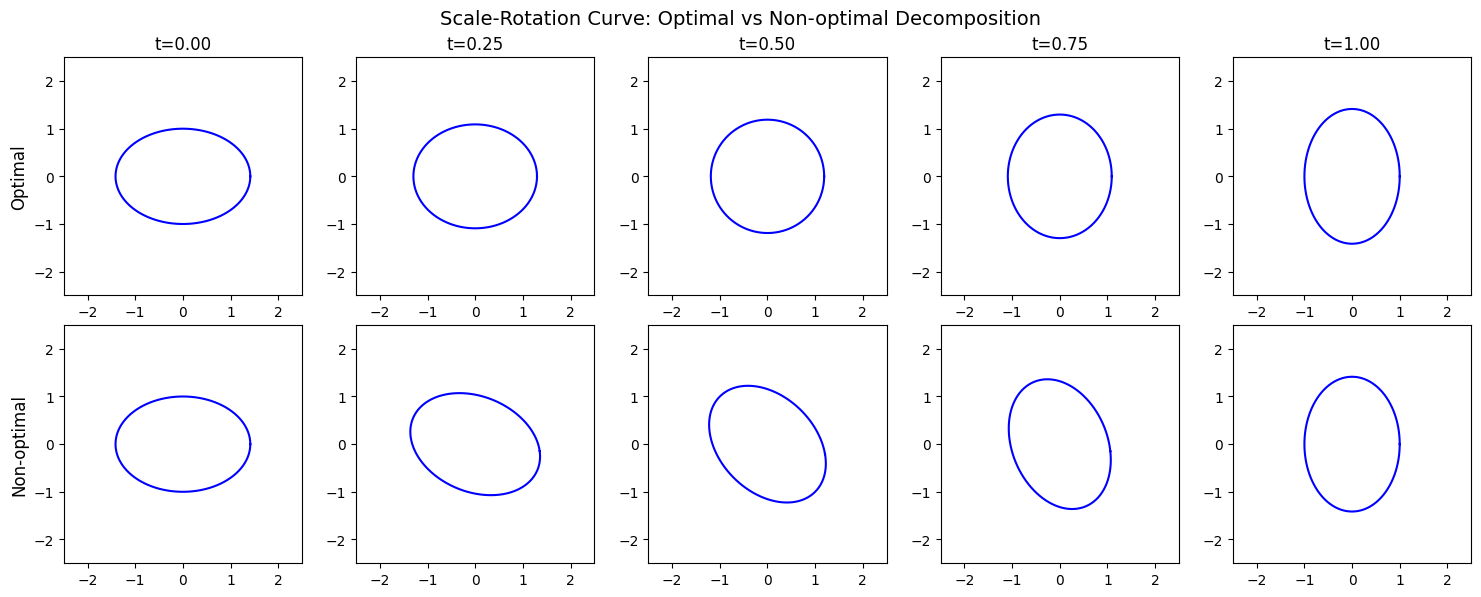

In [26]:
# Re-import required modules
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations, product
from scipy.linalg import logm, expm, sqrtm, eigh

def plot_spd_ellipse(S, ax, color='green', radius=2.5):
    theta = np.linspace(0, 2 * np.pi, 200)
    circle = np.vstack((np.cos(theta), np.sin(theta)))
    ell = sqrtm(S) @ circle
    ax.plot(ell[0, :], ell[1, :], color=color)
    ax.set_aspect('equal')
    ax.set_xlim(-radius, radius)
    ax.set_ylim(-radius, radius)
    # ax.axis('off') # Hide axis

# Example (same as the 3rd simple case before)
X = np.diag([2, 1])
Y = np.diag([1, 2])
t_vals = np.linspace(0, 1, 5)

best_pair, all_pairs = find_optimal_decomposition_pair_SO(X, Y, k=1.0)

# Find a non-optimal pair
for alt_pair in all_pairs:
    if not all(np.allclose(a, b) for a, b in zip(alt_pair[:4], best_pair)):
        non_best_pair = alt_pair[:4]
        break

fig, axes = plt.subplots(2, len(t_vals), figsize=(15, 6))
for i, t in enumerate(t_vals):
    S_best = curve_from_decomposition(*best_pair, t) # The function curve_from_decomposition of compute curve has been defined above
    plot_spd_ellipse(S_best, axes[0, i], color='blue')
    axes[0, i].set_title(f"t={t:.2f}")

    S_alt = curve_from_decomposition(*non_best_pair, t)
    plot_spd_ellipse(S_alt, axes[1, i], color='blue')

axes[0, 0].set_ylabel("Optimal", fontsize=12)
axes[1, 0].set_ylabel("Non-optimal", fontsize=12)
fig.suptitle("Scale-Rotation Curve: Optimal vs Non-optimal Decomposition", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

Change another example (better)

In [27]:
def plot_spd_ellipse(S, ax, color='green', radius=2.5, linewidth=3):
    theta = np.linspace(0, 2 * np.pi, 200)
    circle = np.vstack((np.cos(theta), np.sin(theta)))
    ell = sqrtm(S) @ circle
    ax.plot(ell[0, :], ell[1, :], color=color)
    ax.set_aspect('equal')
    ax.set_xlim(-radius, radius)
    ax.set_ylim(-radius, radius)
    ax.axis('off') # Hide axis

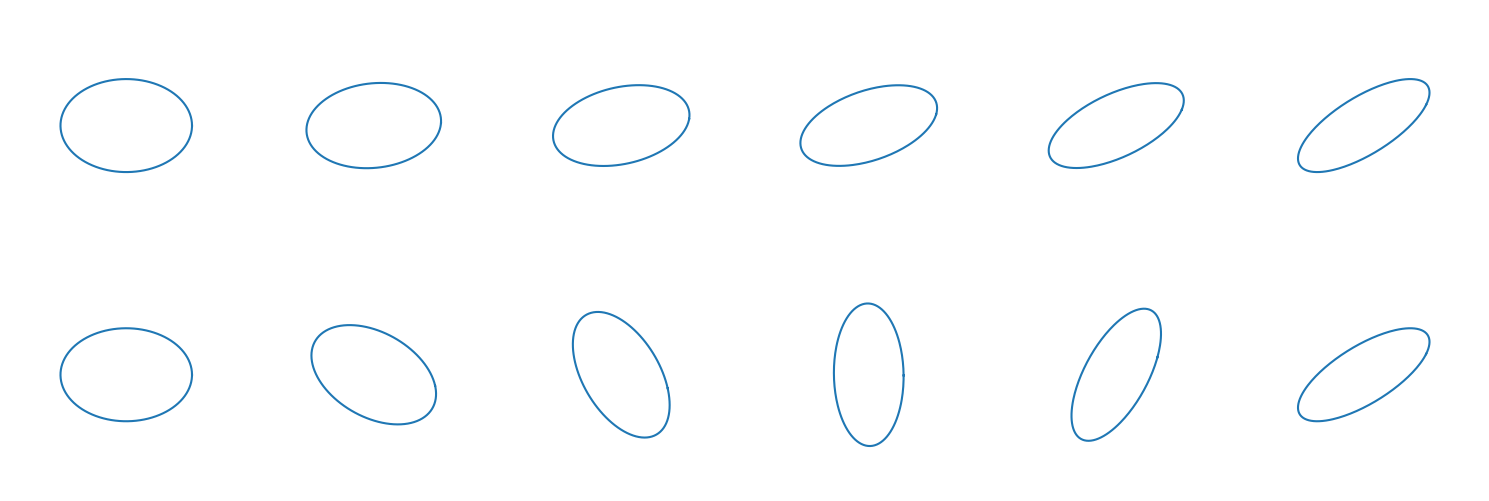

In [28]:
X = np.diag([2, 1])
Y = np.array([[2, 1],[1, 1]]) # Rotate
t_vals = np.linspace(0, 1, 6)

best_pair, all_pairs = find_optimal_decomposition_pair_SO(X, Y, k=1.0)

# Find a non-optimal pair
for alt_pair in all_pairs:
    if not all(np.allclose(a, b) for a, b in zip(alt_pair[:4], best_pair)):
        non_best_pair = alt_pair[:4]
        break

fig, axes = plt.subplots(2, len(t_vals), figsize=(15, 6))
for i, t in enumerate(t_vals):
    S_best = curve_from_decomposition(*best_pair, t)
    plot_spd_ellipse(S_best, axes[0, i], color='tab:blue', linewidth=3)
    #axes[0, i].set_title(f"t={t:.2f}")

    S_alt = curve_from_decomposition(*non_best_pair, t)
    plot_spd_ellipse(S_alt, axes[1, i], color='tab:blue', linewidth=3)

axes[0, 0].set_ylabel("Optimal", fontsize=12)
axes[1, 0].set_ylabel("Non-optimal", fontsize=12)
#fig.suptitle("Scale-Rotation Curve: Optimal vs Non-optimal Decomposition", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()